This script contains code for test number 2, model 3.

In [1]:
import pandas as pd
import os
import glob
import cv2
import numpy as np
import json
import math
from keras import layers
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense,Resizing, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Masking, MaxPooling2D, Lambda,UpSampling2D, Reshape, Input
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from sklearn.preprocessing import MaxAbsScaler
from random import shuffle
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
import keras_cv
from keras_cv.models import YOLOV8Backbone

In [ ]:
##Usefull functions

# Function to create a DataFrame from circular annotations in multiple CSV files
def create_df(path_annotations_circle):
    # Collects all CSV file paths in the specified directory
    all_files = glob.glob(path_annotations_circle + "\\*.csv")

    # Concatenates data from all CSV files into a single DataFrame
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

    # Selects only the columns related to circle annotations: name, center coordinates, and radius
    df_circle = df[['name', 'c-x', 'c-y', 'radius']]

    # Returns the filtered DataFrame
    return df_circle


# Function to find the maximum number of circular objects in any single image
def get_max_number(df_circle):
    # Groups the DataFrame by 'name' and counts the number of entries per group
    value = df_circle.groupby('name').agg('count').sort_values('radius', ascending=False).max()[['radius']].tolist()

    # Returns the maximum count
    return value[0]


def get_bbox_cords(df_circle):
    # Group the dataframe by the 'name' column
    gb = df_circle.groupby('name')    
    gb = [gb.get_group(x) for x in gb.groups]

    list =[]
    for set_of_df in gb:
        lista = []
        for i in range(18*3):
            # Check if the 'radius' value is NaN, append 0 if true
            if str(set_of_df['radius'].values.tolist()[0]) == 'nan':
                lista.append(0)
            else:
                # Stack and convert 'c-x', 'c-y', and 'radius' columns to a list
                lista = set_of_df[['c-x','c-y','radius']].stack().tolist()
                # Calculate the number of zeros needed to reach 54 elements
                number = 54 - len(lista)
                a = [0]*number
                # Extend the list with zeros
                lista = lista + a
                break
        # Add the processed list to the main list
        list.append(lista)

    return list


def get_bbox_cords_to_dict(df_circle):
    # Group the dataframe by the 'name' column
    gb = df_circle.groupby('name')    
    gb = [gb.get_group(x) for x in gb.groups]

    dict = {}
    list = []
    for set_of_df in gb:
        # Extract the name, remove '.csv' from it, and use it as a key
        name = (set_of_df['name'].values.tolist()[0].replace('.csv', ''))
        lista = []
        for i in range(18*3):
            # Check if the 'radius' value is NaN, append 0 if true
            if str(set_of_df['radius'].values.tolist()[0]) == 'nan':
                lista.append(0)
            else:
                # Stack and convert 'c-x', 'c-y', and 'radius' columns to a list
                lista = set_of_df[['c-x','c-y','radius']].stack().tolist()
                # Calculate the number of zeros needed to reach 54 elements
                number = 54 - len(lista)
                a = [0]*number
                # Extend the list with zeros
                lista = lista + a
                break
        # Add the processed list to the main list
        list.append(lista)
        # Update the dictionary with the name and the corresponding list
        dict.update({name:lista})

    return dict


def get_image_data(imagespath):
    # Get all .png file paths in the specified directory
    path = glob.glob(imagespath + '\\*.png')
    # Read each image file and add to the images list
    images = [cv2.imread(file) for file in path]
    return images



#This function applies threshold and split predicted data into list of lists with three coords
def apply_threshold_and_split_pred(trainprediction, thresh):
    prediction = []
    three_coord_list = []
    iter = 0
    prediction_threshold = trainprediction

    # Apply threshold to prediction data
    for i in range(len(prediction_threshold[0])):
        if prediction_threshold[0][i] < thresh:
            prediction_threshold[0][i] = 0

    # Split the thresholded data into lists of three coordinates each
    for elem in prediction_threshold[0]:
        if iter < 3:
            three_coord_list.append(elem)
            iter += 1
        else:
            iter = 1
            prediction.append(three_coord_list)
            three_coord_list = [elem]
    prediction.append(three_coord_list)

    return prediction


#This function applies threshold and split predicted data into list of lists with three coords
def split_origin(origin_img):
    origin = []
    three_coord_list = []
    iter = 0

    # Iterate over each element in the input list
    for elem in origin_img:
        # Add elements to the sublist until three elements are added
        if iter < 3:
            three_coord_list.append(elem)
            iter += 1
        else:
            # Once three elements are added, start a new sublist
            iter = 1
            origin.append(three_coord_list)
            three_coord_list = [elem]
    # Add the final sublist to the main list
    origin.append(three_coord_list)

    return origin


#Draw circles on img
def draw_circle(ax, Color, coords):
    # Iterate over each set of coordinates in coords
    for elem in coords:
        # Extract x, y, and radius from the current element and convert to float
        x = float(elem[0])
        y = float(elem[1])
        radius = float(elem[2])
        # Create a circle with the given coordinates and radius
        circ = Circle((x, y), radius, fill=False, color=Color)
        # Add the circle to the Axes object
        ax.add_patch(circ)
    return ax



#Plot img with results and original img coords
def plot_results(img, prediction, original_coords):
    # Create a figure with equal aspect ratio
    fig, ax = plt.subplots(1)
    ax.imshow(img, interpolation='nearest')  # Display the image

    # Draw circles for predicted coordinates in red
    ax = draw_circle(ax, 'Red', prediction)
    # Draw circles for original coordinates in blue
    ax = draw_circle(ax, 'Blue', original_coords)

    plt.show()  # Display the plot


#Calculate intersection over union 
def calculate_iou(prediction, original_coords):
    iter = 0 
    iou_list = []
    for pred_elem, original_elem in zip(prediction, original_coords):
        iter += 1
        # Extract coordinates and radius for prediction and original circles
        c1_x, c1_y, r1 = pred_elem
        c2_x, c2_y, r2 = original_elem

        # Handle case when original circle is absent
        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = 'NoOriginObject'
        else:
            # Calculate Euclidean distance between centers of two circles
            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            
            # Cases for different spatial relations between the two circles
            if distance > r1 + r2:  # No intersection
                iou = 0.0
            elif distance <= abs(r1 - r2):  # One circle within the other
                intersection_area = np.pi * min(r1, r2)**2
            else:
                # Calculate intersection area when circles partially overlap
                alpha = 2 * np.arccos((r1**2 + distance**2 - r2**2) / (2 * r1 * distance))
                beta = 2 * np.arccos((r2**2 + distance**2 - r1**2) / (2 * r2 * distance))
                a1 = 0.5 * beta * r2**2 - 0.5 * r2**2 * np.sin(beta)
                a2 = 0.5 * alpha * r1**2 - 0.5 * r1**2 * np.sin(alpha)
                intersection_area = a1 + a2

            # Calculate union area and IOU
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2
            union_area = area1 + area2 - intersection_area
            iou = intersection_area / union_area

        # Append IOU to the list and print details
        iou_list.append(iou)
        print(f'{iter}: Original: {original_elem} | Predicted: {pred_elem} | IOU: {iou}')

    return iou_list


#Calculate intersection over union with probability
def calculate_iou_with_probability(prediction, original_coords, probability):
    iter = 0 
    iou_list = []
    for pred_elem, original_elem in zip(prediction, original_coords):
        iter += 1
        # Extract coordinates and radius from prediction and original circles
        c1_x, c1_y, r1 = pred_elem
        c2_x, c2_y, r2 = original_elem

        # Handle case when original circle is absent
        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = 'NoOriginObject'
        else:
            # Calculate Euclidean distance between centers of two circles
            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            
            # Cases for different spatial relations between the two circles
            if distance > r1 + r2:  # No intersection
                iou = 0.0
            elif distance <= abs(r1 - r2):  # One circle within the other
                intersection_area = np.pi * min(r1, r2)**2
            else:
                # Calculate intersection area when circles partially overlap
                alpha = 2 * np.arccos((r1**2 + distance**2 - r2**2) / (2 * r1 * distance))
                beta = 2 * np.arccos((r2**2 + distance**2 - r1**2) / (2 * r2 * distance))
                a1 = 0.5 * beta * r2**2 - 0.5 * r2**2 * np.sin(beta)
                a2 = 0.5 * alpha * r1**2 - 0.5 * r1**2 * np.sin(alpha)
                intersection_area = a1 + a2

            # Calculate union area and IOU
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2
            union_area = area1 + area2 - intersection_area
            iou = intersection_area / union_area

        # Append IOU to the list and print details with probability
        iou_list.append(iou)
        print(f'{iter}: Original: {original_elem} | Predicted: {pred_elem} | Probability: {round(float(probability[0][iter-1]), 3)} | IOU: {iou}')

    return iou_list


#Calculating probabilities for each img
def calculate_prob(list_of_coords):
    list_of_prob = []
    for set_ in list_of_coords:
        probability = []
        # Extract every third element from the set (assuming they represent a specific property of interest)
        lst = set_[::3]
        # Iterate over the extracted elements
        for value in lst:
            # Assign a probability of 1 if the value is not zero, otherwise 0
            probability.append(1 if value != 0 else 0)
        # Append the calculated probabilities for the current set to the main list
        list_of_prob.append(probability)
    
    return list_of_prob



#Adding all data to list of list to enable shuffling data set
def dataset_shuffle(images, list_of_prob, list_of_coords, bool):
    # This function shuffles a dataset consisting of images, probabilities, and coordinates
    if bool == True:  # If 'bool' is True, proceed with shuffling
        whole_set = []  # Initialize an empty list to store combined data
        # Zip and iterate over images, probabilities, and coordinates
        for img, prob, coord in zip(images, list_of_prob, list_of_coords):
            # Combine each image's data into a single list
            one_set = [img, prob, coord]  
            whole_set.append(one_set)  # Add the combined data to 'whole_set'

        shuffle(whole_set)  # Shuffle the 'whole_set' list

        # Initialize empty lists to store shuffled data separately
        img_sh, prob_sh, coord_sh = [], [], []

        # Extract shuffled data back into separate lists
        for set_ in whole_set:
            img_sh.append(set_[0])  # Append shuffled images
            prob_sh.append(set_[1])  # Append shuffled probabilities
            coord_sh.append(set_[2])  # Append shuffled coordinates

        return img_sh, prob_sh, coord_sh  # Return the shuffled datasets
    else:
        # If 'bool' is False, return the original datasets without shuffling
        return images, list_of_prob, list_of_coords


def reverse_transform_data_only_coords(data, grid_size):
    # This function reverses the transformation on coordinate data

    # Fixed dimensions of the image
    image_height, image_width = 202, 308
    # Calculate height and width of each cell in the grid based on the image dimensions and grid size
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    coords_final = []  # Initialize an empty list to store the final coordinates

    # Iterate over the data after reshaping it to match the grid structure
    for batch_data in data.reshape((-1, grid_size[0] * grid_size[1], 3)):
        batch_coords = []  # Initialize a list to store coordinates for the current batch

        # Iterate over each cell in the grid
        for y in range(grid_size[0]):  # Iterate over rows
            for x in range(grid_size[1]):  # Iterate over columns
                # Extract local coordinates and radius from the batch data
                local_x, local_y, r = batch_data[y * grid_size[1] + x]
                # Calculate global coordinates by adding the local offset to the top-left corner of each cell
                global_x = x * cell_width + local_x
                global_y = y * cell_height + local_y

                # Add the global coordinates and radius to the batch coordinates list
                batch_coords.extend([global_x, global_y, r])

        # Add the batch coordinates to the final list
        coords_final.append(batch_coords)

    return coords_final  # Return the list of transformed coordinates


def reverse_transform_deep_nested_coords(batch_data, grid_size, max_box_per_apple=2):
    # Function to reverse transform nested coordinates in a batch of data

    # Fixed dimensions of the image
    image_height, image_width = 202, 308
    # Calculate height and width of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Initialize an empty list to store the global coordinates
    output_list = []

    # Iterate over each cell in the grid
    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            # Check if there are two boxes per apple
            if max_box_per_apple == 2:
                # Extract local coordinates from the first and second boxes in the current cell
                local_coords1 = batch_data[0][y][x][0]
                local_coords2 = batch_data[0][y][x][1]

                # Convert local coordinates of the first box to global coordinates
                global_x1 = x * cell_width + local_coords1[0]
                global_y1 = y * cell_height + local_coords1[1]

                # Convert local coordinates of the second box to global coordinates
                global_x2 = x * cell_width + local_coords2[0]
                global_y2 = y * cell_height + local_coords2[1]

                # Append global coordinates and radius of both boxes to the output list
                output_list.extend([global_x1, global_y1, local_coords1[2],
                                    global_x2, global_y2, local_coords2[2]])
            elif max_box_per_apple == 1:
                # Extract local coordinates from the first box in the current cell
                local_coords1 = batch_data[0][y][x][0]

                # Convert local coordinates to global coordinates
                global_x1 = x * cell_width + local_coords1[0]
                global_y1 = y * cell_height + local_coords1[1]

                # Append global coordinates and radius of the box to the output list
                output_list.extend([global_x1, global_y1, local_coords1[2]])

    return np.array(output_list)  # Convert the output list to a NumPy array and return it

    
def reverse_transform_deep_nested_coords_and_normalization(batch_data, grid_size, max_box_per_apple=2):
    # Function to reverse transform and normalize coordinates in a batch of data

    # Fixed dimensions of the image
    image_height, image_width = 202, 308
    # Calculate height, width, and diagonal of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    cell_diagonal = math.sqrt(cell_height**2 + cell_width**2)

    # Initialize an empty list to store the output
    output_list = []

    # Iterate over each cell in the grid
    for y in range(grid_size[0]):
        for x in range(grid_size[1]):
            # Check if there are two boxes per apple
            if max_box_per_apple == 2:
                # Extract local coordinates from the first and second boxes in the current cell
                local_coords1 = batch_data[0][y][x][0]
                local_coords2 = batch_data[0][y][x][1]

                # Normalize and convert local coordinates of the first box to global coordinates
                global_x1 = x * cell_width + local_coords1[0] * cell_width
                global_y1 = y * cell_height + local_coords1[1] * cell_height

                # Normalize and convert local coordinates of the second box to global coordinates
                global_x2 = x * cell_width + local_coords2[0] * cell_width
                global_y2 = y * cell_height + local_coords2[1] * cell_height

                # Append global coordinates and normalized radius of both boxes to the output list
                output_list.extend([global_x1, global_y1, local_coords1[2] * cell_diagonal,
                                    global_x2, global_y2, local_coords2[2] * cell_diagonal])
            elif max_box_per_apple == 1:
                # Extract local coordinates from the first box in the current cell
                local_coords1 = batch_data[0][y][x][0]

                # Normalize and convert local coordinates to global coordinates
                global_x1 = x * cell_width + local_coords1[0] * cell_width
                global_y1 = y * cell_height + local_coords1[1] * cell_height

                # Append global coordinates and normalized radius of the box to the output list
                output_list.extend([global_x1, global_y1, local_coords1[2] * cell_diagonal])

    return np.array(output_list)  # Convert the output list to a NumPy array and return it


#Calculate intersection over union 
def Iou(prediction, original_coords):
    # This function calculates the Intersection over Union (IoU) for pairs of circles

    iter = 0  # Initialize an iterator for looping through the elements
    iou_list = []  # Initialize a list to store IoU values

    # Iterate over each pair of predicted and original coordinates
    for pred_elem, original_elem in zip(prediction, original_coords):
        iter += 1  # Increment the iterator

        # Extract center coordinates and radii from the predicted and original elements
        c1_x, c1_y, r1 = pred_elem  # Prediction: center x, center y, radius
        c2_x, c2_y, r2 = original_elem  # Original: center x, center y, radius

        # Check for a special case where original coordinates are all zeros
        if c2_x == 0 and c2_y == 0 and r2 == 0:
            iou = -1
        else:
            # Calculate the distance between the centers of the circles
            distance = np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
            
            # Case: Circles do not intersect
            if distance > r1 + r2:
                return [0.0]
            # Case: One circle is entirely within the other
            elif (distance <= (r1 - r2) and r1 >= r2):
                intersection_area = np.pi * r2 * r2
        
            elif (distance <= (r2 - r1) and r2 >= r1):
                intersection_area = np.pi * r1 * r1
        
            else :
                alpha = np.arccos(((r1 * r1) + (distance * distance) - (r2 * r2)) / (2 * r1 * distance)) * 2
                beta = np.arccos(((r2 * r2) + (distance * distance) - (r1 * r1)) / (2 * r2 * distance)) * 2
                
                a1 = (0.5 * beta * r2 * r2 ) - (0.5 * r2 * r2 * np.sin(beta))
                a2 = (0.5 * alpha * r1 * r1) - (0.5 * r1 * r1 * np.sin(alpha))
                intersection_area = a1 + a2
                
            area1 = np.pi * r1**2
            area2 = np.pi * r2**2
            # Calculate the union area
            union_area = area1 + area2 - intersection_area
                
            # Calculate IOU
            iou = intersection_area / union_area

        iou_list.append(iou)

    return iou_list  # Return the list of IoU values


#Function applies Non-Max Suppression algorithm on model output
def NMS(pred, iou_threshold, prob_threshold, prob):
    # Function implementing the Non-Maximum Suppression (NMS) algorithm

    # Initialize lists to store predictions with probabilities
    one_box = []
    predictions_with_prob = []
    iter = 0
    iter_prob = 0

    # Iterate over predicted elements to associate them with their probabilities
    for elem in pred:
        if iter == 2:  # Every third element (0-indexed)
            iter = 0
            one_box.append(elem)  # Add the third element (radius) to one_box
            one_box.append(prob[iter_prob])  # Add the associated probability to one_box
            iter_prob += 1
            predictions_with_prob.append(one_box)  # Add the complete box with probability to the list
            one_box = []  # Reset one_box for next iteration
        else:
            one_box.append(elem)  # Add x and y coordinates to one_box
            iter += 1

    # NMS algorithm implementation
    bbox_list_thresholded = []  # List to store boxes that pass the probability threshold
    bbox_list_new = []  # List to store final boxes after applying NMS

    # Sort boxes by probability and filter out those below the probability threshold
    box_sorted = sorted(predictions_with_prob, reverse=True, key=lambda x: x[3])
    for box in box_sorted:
        if box[3] > prob_threshold:
            bbox_list_thresholded.append(box)

    # Remove overlapping boxes based on IoU threshold
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)  # Select and remove the highest probability box
        bbox_list_new.append(current_box)  # Add it to the final list
        # Check IoU with remaining boxes and remove those with IoU greater than the threshold
        for box in list(bbox_list_thresholded):  # Iterate over a copy of the list to safely remove items
            iou = Iou([current_box[:3]], [box[:3]])  # Calculate IoU
            if iou[0] > iou_threshold:
                bbox_list_thresholded.remove(box)

    return bbox_list_new  # Return the final list of boxes after applying NMS


def transform_data(coords, probs, grid_size, max_apples_per_cell=2):
    # Function to transform coordinates and probabilities into a grid format

    # Fixed dimensions of the input image
    image_height, image_width = 202, 308
    
    transformed_coords_final = []  # List to store final transformed coordinates
    transformed_probs_final = []  # List to store final transformed probabilities

    # Calculate the size of each grid cell
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]

    # Iterate over each apple
    for i in range(len(probs)):
        # Initialize tensors to store transformed coordinates and probabilities
        transformed_coords = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 3))
        transformed_probs = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 1))

        # Counter for apples in each cell
        apple_counter = np.zeros((grid_size[0], grid_size[1]), dtype=int)

        for j in range(len(probs[0])):
            if probs[i][j] == 1:  # Check if the apple exists
                # Extract coordinates and radius for this apple
                x, y, r = coords[i][j*3:j*3+3]

                # Determine the grid cell in which the apple is located
                cell_x, cell_y = int(np.floor(x // cell_width)), int(np.floor(y // cell_height))
                
                # Adjust coordinates to local cell coordinates
                local_x = (x % cell_width)
                local_y = (y % cell_height)
                
                # Check if the maximum apples per cell limit has not been exceeded
                if apple_counter[cell_y, cell_x] < max_apples_per_cell:
                    # Update the output tensors
                    idx = apple_counter[cell_y, cell_x]
                    transformed_coords[cell_y, cell_x, idx] = [local_x, local_y, r]
                    transformed_probs[cell_y, cell_x, idx] = [1]  # Set probability to 1
                    
                    # Update the apple counter for this cell
                    apple_counter[cell_y, cell_x] += 1

        # Convert numpy arrays to lists and append to final lists
        transformed_coords_final.append(transformed_coords.tolist())
        transformed_probs_final.append(transformed_probs.tolist())

    return transformed_coords_final, transformed_probs_final  # Return the transformed data


def transform_data_and_normalize(coords, probs, grid_size, max_apples_per_cell=2):
    # Function to transform and normalize coordinates and probabilities into a grid format

    # Fixed dimensions of the input image
    image_height, image_width = 202, 308
    
    transformed_coords_final = []  # List to store final transformed and normalized coordinates
    transformed_probs_final = []  # List to store final transformed probabilities

    # Calculate the size of each grid cell and the diagonal of a cell
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    cell_diagonal = math.sqrt(cell_height**2 + cell_width**2)

    # Iterate over each set of probabilities (each apple)
    for i in range(len(probs)):
        # Initialize tensors for transformed coordinates and probabilities
        transformed_coords = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 3))
        transformed_probs = np.zeros((grid_size[0], grid_size[1], max_apples_per_cell, 1))

        # Counter for apples in each cell
        apple_counter = np.zeros((grid_size[0], grid_size[1]), dtype=int)

        for j in range(len(probs[0])):
            if probs[i][j] == 1:  # Check if the apple exists
                # Extract coordinates and radius for this apple
                x, y, r = coords[i][j*3:j*3+3]

                # Determine the grid cell in which the apple is located
                cell_x, cell_y = int(np.floor(x // cell_width)), int(np.floor(y // cell_height))
                
                # Normalize coordinates to local cell coordinates and radius to cell diagonal
                local_x = (x % cell_width) / cell_width
                local_y = (y % cell_height) / cell_height
                normalized_r = r / cell_diagonal
                
                # Check if the maximum apples per cell limit has not been exceeded
                if apple_counter[cell_y, cell_x] < max_apples_per_cell:
                    # Update the output tensors
                    idx = apple_counter[cell_y, cell_x]
                    transformed_coords[cell_y, cell_x, idx] = [local_x, local_y, normalized_r]
                    transformed_probs[cell_y, cell_x, idx] = [1]  # Set probability to 1
                    
                    # Update the apple counter for this cell
                    apple_counter[cell_y, cell_x] += 1

        # Convert numpy arrays to lists and append to final lists
        transformed_coords_final.append(transformed_coords.tolist())
        transformed_probs_final.append(transformed_probs.tolist())

    return transformed_coords_final, transformed_probs_final  # Return the transformed and normalized data


def reverse_transform_data(data, grid_size):
    # Function to reverse transform data from grid format to global coordinates

    # Fixed dimensions of the input image
    image_height, image_width = 202, 308
    # Calculate the size of each cell in the grid
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    
    coords_final = []  # List to store final global coordinates
    probs_final = []  # List to store probabilities associated with each coordinate

    # Iterate over each batch of data
    for batch_data in data:
        batch_coords = []  # List to store coordinates for the current batch
        batch_probs = []   # List to store probabilities for the current batch

        # Iterate over each cell in the grid
        for y in range(grid_size[0]):
            for x in range(grid_size[1]):
                # Iterate over each apple data in the cell
                for apple_data in batch_data[y][x]:
                    # Extract local coordinates, radius, and probability
                    local_x, local_y, r, prob = apple_data

                    # Convert local coordinates to global coordinates
                    global_x = x * cell_width + local_x
                    global_y = y * cell_height + local_y
                    
                    # Extend the batch_coords list with the global coordinates and radius
                    batch_coords.extend([global_x, global_y, r])
                    # Append the probability to the batch_probs list
                    batch_probs.append(prob)  # Probability indicates the existence of the apple

        # Append the coordinates and probabilities for this batch to the final lists
        coords_final.append(batch_coords)
        probs_final.append(batch_probs)

    return coords_final, probs_final  # Return the final global coordinates and probabilities


def reverse_transform_data_and_normalization(data, grid_size):
    # Function to reverse transform and denormalize data from grid format to global coordinates

    # Fixed dimensions of the input image
    image_height, image_width = 202, 308
    # Calculate the size of each cell in the grid and its diagonal
    cell_height, cell_width = image_height / grid_size[0], image_width / grid_size[1]
    cell_diagonal = math.sqrt(cell_height**2 + cell_width**2)

    coords_final = []  # List to store final global coordinates
    probs_final = []  # List to store probabilities associated with each coordinate

    # Iterate over each batch of data
    for batch_data in data:
        batch_coords = []  # List to store coordinates for the current batch
        batch_probs = []   # List to store probabilities for the current batch

        # Iterate over each cell in the grid
        for y in range(grid_size[0]):
            for x in range(grid_size[1]):
                # Iterate over each apple data in the cell
                for apple_data in batch_data[y][x]:
                    # Extract normalized local coordinates, radius, and probability
                    local_x, local_y, r, prob = apple_data

                    # Convert normalized local coordinates to global coordinates and denormalize the radius
                    global_x = x * cell_width + local_x * cell_width
                    global_y = y * cell_height + local_y * cell_height
                    global_r = r * cell_diagonal
                    
                    # Extend the batch_coords list with the global coordinates and denormalized radius
                    batch_coords.extend([global_x, global_y, global_r])
                    # Append the probability to the batch_probs list
                    batch_probs.append(prob)  # Probability indicates the existence of the apple

        # Append the coordinates and probabilities for this batch to the final lists
        coords_final.append(batch_coords)
        probs_final.append(batch_probs)

    return coords_final, probs_final  # Return the final global coordinates and probabilities


In [9]:
path_img_test = r'datasets_splited\dataset\test_aug\images'
path_csv_test = r'datasets_splited\dataset\test_aug\annotations'

path_img_train = r'datasets_splited\dataset\train_aug\images'
path_csv_train = r'datasets_splited\dataset\train_aug\annotations'

path_img_val = r'datasets_splited\dataset\val_aug\images'
path_csv_val = r'datasets_splited\dataset\val_aug\annotations'

grid_size = (7,10)

df_circle_test = create_df(path_csv_test)
list_of_coords_test = get_bbox_cords(df_circle_test)
images_test = get_image_data(path_img_test)
list_of_prob_test = calculate_prob(list_of_coords_test)

df_circle_train = create_df(path_csv_train)
list_of_coords_train = get_bbox_cords(df_circle_train)
images_train = get_image_data(path_img_train)
list_of_prob_train = calculate_prob(list_of_coords_train)

df_circle_val = create_df(path_csv_val)
list_of_coords_val = get_bbox_cords(df_circle_val)
images_val = get_image_data(path_img_val)
list_of_prob_val = calculate_prob(list_of_coords_val)

transformed_coords_test, transformed_probs_test = transform_data_and_normalize(list_of_coords_test, list_of_prob_test, grid_size,max_apples_per_cell=1)
transformed_coords_train, transformed_probs_train = transform_data_and_normalize(list_of_coords_train, list_of_prob_train, grid_size,max_apples_per_cell=1)
transformed_coords_val, transformed_probs_val = transform_data_and_normalize(list_of_coords_val, list_of_prob_val, grid_size,max_apples_per_cell=1)

for i in range(len(images_test)):
    images_test[i] = images_test[i] / 255

for i in range(len(images_train)):
    images_train[i] = images_train[i] / 255

for i in range(len(images_val)):
    images_val[i] = images_val[i] / 255

test_set_coords = np.array(transformed_coords_test)
test_set_img = np.array(images_test)
test_set_prob = transformed_probs_test

train_set_coords = np.array(transformed_coords_train)
train_set_img = np.array(images_train)
train_set_prob = transformed_probs_train

valid_set_coords = np.array(transformed_coords_val)
valid_set_img = np.array(images_val)
valid_set_prob = transformed_probs_val

print(len(test_set_coords))
print(len(test_set_img))
print(len(train_set_coords))
print(len(train_set_img))
print(len(valid_set_coords))
print(len(valid_set_img))
print(len(train_set_prob))
print(len(test_set_prob))
print(len(valid_set_prob))


train_labels = np.concatenate([train_set_coords, train_set_prob], axis=-1)
valid_labels = np.concatenate([valid_set_coords, valid_set_prob], axis=-1)

448
448
3584
3584
448
448
3584
448
448


In [10]:
train_labels = train_labels[:300]
valid_labels = train_labels[:40]
train_set_img = train_set_img[:300]
valid_set_img =  valid_set_img[:40]

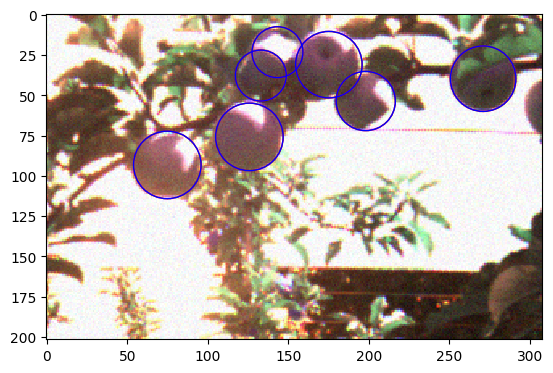

In [77]:
num = 89
grid_size = (7,10)
test_set_coords_tr = reverse_transform_deep_nested_coords_and_normalization([test_set_coords[num]], grid_size, max_box_per_apple=1)
original_coords = split_origin(test_set_coords_tr)
plot_results(test_set_img[num], original_coords, original_coords)

In [33]:
grid_size = (7,10)
bbox_per_cell = 1
input_shape = (202, 308, 3)
new_size = (202,308)

inputs = Input(shape=input_shape)
resize_layer = Resizing(new_size[0], new_size[1])(inputs)

base_model = YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco",load_weights=True)

n = 120  
for layer in base_model.layers[:n]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer, layer.trainable)


selected_layer = base_model.layers[171].output

vgg16_truncated = Model(inputs=base_model.input, outputs=selected_layer)

vgg16 = vgg16_truncated(resize_layer)

x = Flatten()(vgg16)

output_channels = bbox_per_cell * 3  
bbox_predictions = Dense(grid_size[0] * grid_size[1] * output_channels, activation='linear', name='bbox_predictions')(x)
bbox_predictions = Reshape((grid_size[0], grid_size[1], bbox_per_cell, 3), name='bbox_predictions_f')(bbox_predictions)  

output_channels_conf = bbox_per_cell * 1
confidence_scores = Dense(grid_size[0] * grid_size[1] * output_channels_conf, activation='sigmoid', name='confidence_scores')(x)
confidence_scores = Reshape((grid_size[0], grid_size[1], bbox_per_cell, 1), name='confidence_scores_f')(confidence_scores)

model = Model(inputs=inputs, outputs=[bbox_predictions, confidence_scores])

model.summary()

def bbox_loss(y_true, y_pred):
    
    lambda_coord = 10.0

    true_xy = y_true[..., 0:2]
    true_r = y_true[..., 2:3]
    true_prob = y_true[..., 3:4]
    
    pred_xy = y_pred[..., 0:2]
    pred_r = y_pred[..., 2:3]
    
    obj_mask = tf.cast(tf.greater(true_prob, 0.5), dtype=tf.float32)  
   
    coord_loss = tf.reduce_sum(tf.square(obj_mask*(true_xy - pred_xy))) + tf.reduce_sum(tf.square(obj_mask*(true_r - pred_r)))
   
    total_bbox_loss = lambda_coord * coord_loss 

    return total_bbox_loss

def conf_loss(y_true, y_pred):

    lambda_noobj = 0.5
    lambda_obj = 7.5

    true_prob = y_true[..., 3:4]
    pred_prob = y_pred[..., 0:1]
   
    obj_mask = tf.cast(tf.greater(true_prob, 0.5), dtype=tf.float32)  
    noobj_mask = 1 - obj_mask  

    obj_loss = tf.reduce_sum(tf.square(obj_mask*(true_prob-pred_prob)))
    noobj_loss = tf.reduce_sum(tf.square(noobj_mask*(true_prob-pred_prob)))   

    total_conf_loss = lambda_obj * obj_loss + lambda_noobj * noobj_loss
    
    return total_conf_loss


custom_optimizer = Adam(learning_rate=1e-4)
model.compile(loss=[bbox_loss, conf_loss], loss_weights=[1.0,1.0], optimizer=custom_optimizer, metrics=['accuracy'
                                                                                                            ])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              min_delta=1e-4, 
                              min_lr=1e-10)

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    elif epoch == 20:
        lr = lr*0.1
        return lr
    elif epoch < 120:
        return lr
    else:
        return lr * (0.98 ** (epoch - 80))


my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50),
    tf.keras.callbacks.ModelCheckpoint(filepath='calls/model.{epoch:02d}-{val_loss:.4f}.h5'),
    tf.keras.callbacks.LearningRateScheduler(scheduler),

]

history_y1 = model.fit(
    train_set_img,  
    train_labels,   
    batch_size=64,
    epochs=600,
    verbose=2,
    shuffle=True,
    validation_data=(valid_set_img, valid_labels),  
    callbacks=my_callbacks
)

model.save('models/y6_model.h5')

<keras.src.engine.input_layer.InputLayer object at 0x0000020D661A9350> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000020D6629E0D0> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000020D66368BD0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020D6622C850> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x0000020D66217250> False
<keras.src.layers.core.activation.Activation object at 0x0000020D661A8710> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000020B9BB2BED0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020D66233150> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x0000020D6635D3D0> False
<keras.src.layers.core.activation.Activation object at 0x0000020B9C0B2510> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000020D663BBD50> False
<keras.src.layers

KeyboardInterrupt: 

1/1 [==============================] - 1s 961ms/step
[array([[[[[-1.9984934e-02,  2.7617282e-01,  4.0911695e-01]],

         [[ 3.0729246e-01,  4.6919840e-03, -4.3420805e-04]],

         [[ 3.0632341e-01,  4.7892624e-01,  1.9796701e-02]],

         [[ 1.1888442e+00,  4.4974643e-01,  6.2587243e-01]],

         [[ 6.4672536e-01,  4.8410898e-01, -1.3610019e-01]],

         [[ 5.0534683e-01,  2.9493040e-01,  6.7995101e-01]],

         [[ 1.8836051e-01,  3.1130233e-01,  2.7878818e-01]],

         [[ 6.7172563e-01,  5.0007659e-01,  1.6878428e-01]],

         [[ 7.8081411e-01,  8.6205113e-01,  2.6227212e-01]],

         [[ 3.9975142e-01,  4.0685788e-01,  5.2300525e-01]]],


        [[[ 2.2222868e-01,  1.3200978e+00,  8.6412507e-01]],

         [[ 5.7052171e-01,  2.3792280e-01,  6.7649686e-01]],

         [[-5.8269810e-02,  2.7506348e-01,  5.5065972e-01]],

         [[ 8.2482392e-01, -1.9254988e-01,  5.1075166e-01]],

         [[ 1.6463992e-01,  9.5372450e-01,  4.7568175e-01]],

         [[ 5.

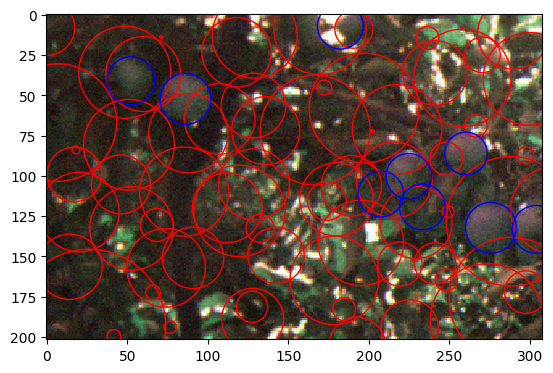

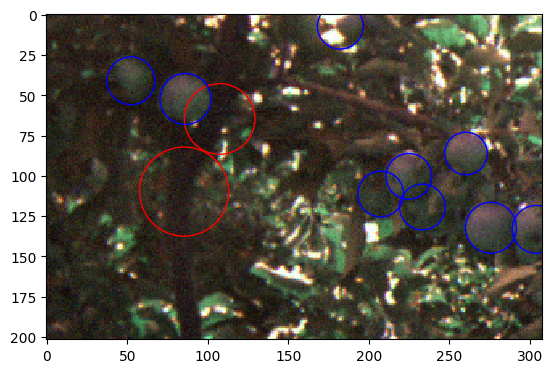

In [34]:
model = load_model(
    r'<your model>',
    compile=False
)

num = 200
grid_size = (7,10)

input_image_reshaped = np.expand_dims(test_set_img[num], axis=0)
predictions=model.predict(input_image_reshaped)
print(predictions)

predictions = np.concatenate((predictions[0], predictions[1]), axis = 4)

dt, probab = reverse_transform_data_and_normalization(predictions, grid_size)
test_set_coords_tr = reverse_transform_deep_nested_coords_and_normalization([test_set_coords[num]], grid_size, max_box_per_apple=1)


prediction = apply_threshold_and_split_pred(dt, 0)
print("Predicted coords",prediction)
print("Predicted probabilities",probab)

before_nms = []
for list_ in prediction:
    for elem in list_:
        before_nms.append(elem)

after_nms = NMS(before_nms,0.05,0.5,probab[0])
only_pred_after_nms = []
for list_ in after_nms:
    only_pred_after_nms.append(list_[:-1])
print("Predicted coords after NMS",only_pred_after_nms)

original_coords = split_origin(test_set_coords_tr)
plot_results(test_set_img[num], prediction, original_coords)
plot_results(test_set_img[num], only_pred_after_nms, original_coords)

1/1 [==============================] - 1s 964ms/step
[array([[[[[ 1.0327404 ,  1.699695  ,  0.33645186]],

         [[ 0.6855756 ,  0.82368356,  0.09800839]],

         [[ 1.2107728 ,  0.37448084,  0.22922295]],

         [[ 1.2728379 ,  1.5600061 , -0.16934499]],

         [[ 0.78616804,  0.2146628 ,  0.18769412]],

         [[ 0.89935696,  0.22021556,  0.02568832]],

         [[-0.06382478, -0.17878714,  0.5463921 ]],

         [[-1.2717215 , -0.08914216, -0.08895174]],

         [[ 0.42098048,  0.01174622,  0.8399637 ]],

         [[ 0.69781065,  1.104293  , -0.3391916 ]]],


        [[[ 0.19597954,  0.6440884 ,  0.541231  ]],

         [[ 0.9578042 ,  0.02266102,  0.8437135 ]],

         [[ 0.8687147 ,  0.13381913,  0.5821787 ]],

         [[ 0.22094524,  0.371985  ,  0.7932498 ]],

         [[ 0.15106374,  0.00223703,  0.7241193 ]],

         [[ 0.48642495,  0.20549849,  0.02210454]],

         [[ 0.19617394,  0.8154149 ,  0.8419712 ]],

         [[ 0.05083463, -0.42898658,  0.552

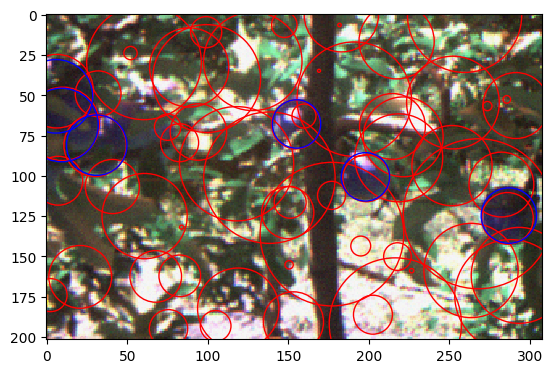

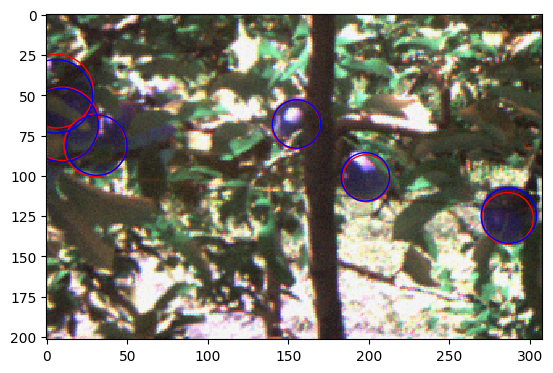

In [45]:
model = load_model(
    r'<your model>',
    compile=False
)

num = 89
grid_size = (7,10)

input_image_reshaped = np.expand_dims(train_set_img[num], axis=0)
predictions=model.predict(input_image_reshaped)
print(predictions)

predictions = np.concatenate((predictions[0], predictions[1]), axis = 4)

dt, probab = reverse_transform_data_and_normalization(predictions, grid_size)
test_set_coords_tr = reverse_transform_deep_nested_coords_and_normalization([train_set_coords[num]], grid_size, max_box_per_apple=1)


prediction = apply_threshold_and_split_pred(dt, 0)
print("Predicted coords",prediction)
print("Predicted probabilities",probab)
print("Origin prob", train_set_prob[num])
before_nms = []
for list_ in prediction:
    for elem in list_:
        before_nms.append(elem)

after_nms = NMS(before_nms,0.7,0.8,probab[0])
only_pred_after_nms = []
for list_ in after_nms:
    only_pred_after_nms.append(list_[:-1])
print("Predicted coords after NMS",only_pred_after_nms)

original_coords = split_origin(test_set_coords_tr)
plot_results(train_set_img[num], prediction, original_coords)
plot_results(train_set_img[num], only_pred_after_nms, original_coords)